# Install AI2-THOR

ProcTHOR houses are loaded into `ai2thor` and distributed with the `prior` package. We'll also install a helper package, called `ai2thor_colab`, which allows us to run AI2-THOR in Google Colab.

Let's install each of these packages below:

In [25]:
# Here, we'll install and use a pre-release of AI2-THOR.
!pip install --upgrade ai2thor --quiet

# Download ProcTHOR-10k

Now, let's use the `prior` package to easily download the `procthor-10k` dataset:

In [26]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 4443.26it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

ProcTHOR-10k comes with 3 splits, including:
- 10k `"train"` houses
- 1k `"val"` houses
- 1k `"test"` houses

these can be obtained by indexing into the dataset:

In [27]:
dataset["train"]

Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
)

Here is an example of how to load a single house's JSON file:

In [ ]:
house = dataset["train"][0]
type(house), house.keys(), house

(dict,
 dict_keys(['doors', 'metadata', 'objects', 'proceduralParameters', 'rooms', 'walls', 'windows']),
 {'doors': [{'assetId': 'Doorway_6',
    'id': 'door|1|2',
    'openable': False,
    'openness': 0,
    'room0': 'room|2',
    'room1': 'room|2',
    'wall0': 'wall|2|5.99|3.99|5.99|5.99',
    'wall1': 'wall|exterior|5.99|3.99|5.99|5.99',
    'holePolygon': [{'x': 0.4987163812589276, 'y': 0, 'z': 0},
     {'x': 1.5362947256040203, 'y': 2.1068506240844727, 'z': 0}],
    'assetPosition': {'x': 1.016530884310268,
     'y': 1.0534253120422363,
     'z': 0}}],
  'metadata': {'agent': {'horizon': 30,
    'position': {'x': 3.5, 'y': 0.95, 'z': 2.0},
    'rotation': {'x': 0, 'y': 90, 'z': 0},
    'standing': True},
   'roomSpecId': 'kitchen',
   'schema': '1.0.0',
   'warnings': {},
   'agentPoses': {'arm': {'horizon': 30,
     'position': {'x': 3.5, 'y': 0.95, 'z': 2.0},
     'rotation': {'x': 0, 'y': 90, 'z': 0},
     'standing': True},
    'default': {'horizon': 30,
     'position': {'

# Load a house into AI2-THOR

First, let's import in a Controller from AI2-THOR:

In [29]:
from ai2thor.controller import Controller

Let's now choose a ProcTHOR house we want to load into AI2-THOR:

In [ ]:
house = dataset["train"][2]

And create a Controller that is initialized to that scene:

In [31]:
controller = Controller(scene=house, renderInstanceSegmentation=True, renderDepthImage=True)

# Egocentric Images

We now have an agent placed in the scene ready to execute actions! Let's check out what it's looking at:

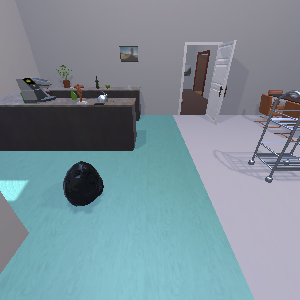

In [32]:
from PIL import Image

Image.fromarray(controller.last_event.frame)

# Top-Down Frame

We can also get a top-down image of the frame:

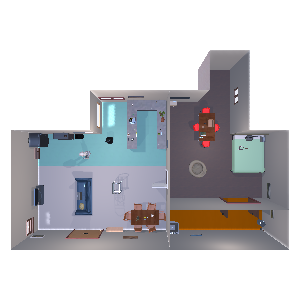

In [33]:
import copy

def get_top_down_frame():
    # Setup the top-down camera
    event = controller.step(action="GetMapViewCameraProperties", raise_for_failure=True)
    pose = copy.deepcopy(event.metadata["actionReturn"])

    bounds = event.metadata["sceneBounds"]["size"]
    max_bound = max(bounds["x"], bounds["z"])

    pose["fieldOfView"] = 50
    pose["position"]["y"] += 1.1 * max_bound
    pose["orthographic"] = False
    pose["farClippingPlane"] = 50
    del pose["orthographicSize"]

    # add the camera to the scene
    event = controller.step(
        action="AddThirdPartyCamera",
        **pose,
        skyboxColor="white",
        raise_for_failure=True,
    )
    top_down_frame = event.third_party_camera_frames[-1]
    return Image.fromarray(top_down_frame)


get_top_down_frame()

# Randomize the Agent's Position

To randomize the agent's position, we can get the set of grid positions that the agent can reach from 90 degree rotations and 0.25m separated movements. Here, we'll call `GetReachablePositions`:

In [38]:
event = controller.step(action="GetReachablePositions")
event.metadata["actionReturn"]

[{'x': 9.75, 'y': 0.9009993672370911, 'z': 6.75},
 {'x': 9.75, 'y': 0.9009993672370911, 'z': 7.0},
 {'x': 9.5, 'y': 0.9009993672370911, 'z': 6.75},
 {'x': 9.75, 'y': 0.9009993672370911, 'z': 6.5},
 {'x': 9.75, 'y': 0.9009993672370911, 'z': 7.25},
 {'x': 9.5, 'y': 0.9009993672370911, 'z': 7.0},
 {'x': 9.25, 'y': 0.9009993672370911, 'z': 6.75},
 {'x': 9.5, 'y': 0.9009993672370911, 'z': 6.5},
 {'x': 9.75, 'y': 0.9009993672370911, 'z': 6.25},
 {'x': 9.75, 'y': 0.9009993672370911, 'z': 7.5},
 {'x': 9.5, 'y': 0.9009993672370911, 'z': 7.25},
 {'x': 9.25, 'y': 0.9009993672370911, 'z': 7.0},
 {'x': 9.0, 'y': 0.9009993672370911, 'z': 6.75},
 {'x': 9.25, 'y': 0.9009993672370911, 'z': 6.5},
 {'x': 9.5, 'y': 0.9009993672370911, 'z': 6.25},
 {'x': 9.75, 'y': 0.9009993672370911, 'z': 6.0},
 {'x': 9.75, 'y': 0.9009993672370911, 'z': 7.75},
 {'x': 9.5, 'y': 0.9009993672370911, 'z': 7.5},
 {'x': 9.25, 'y': 0.9009993672370911, 'z': 7.25},
 {'x': 9.0, 'y': 0.9009993672370911, 'z': 7.0},
 {'x': 8.75, 'y': 

And to visualize these positions, let's plot them on a scatter plot:

1018


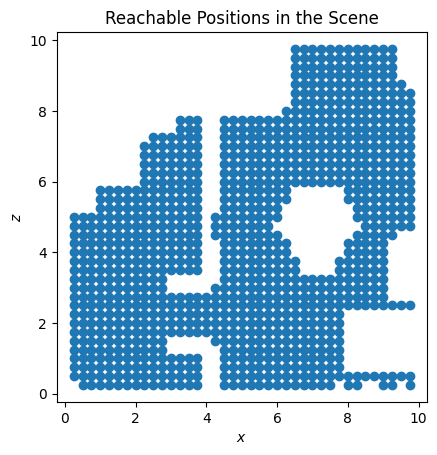

In [ ]:
import matplotlib.pyplot as plt
reachable_positions = event.metadata["actionReturn"]
xs = [rp["x"] for rp in reachable_positions]
zs = [rp["z"] for rp in reachable_positions]

print(len(reachable_positions))

fig, ax = plt.subplots(1, 1)
ax.scatter(xs, zs)
ax.set_xlabel("$x$")
ax.set_ylabel("$z$")
ax.set_title("Reachable Positions in the Scene")
ax.set_aspect("equal")

## List of textured materials to use

In [34]:
usableMaterials = ["BrickSmallNew0073_4_S", "CeramicTiles3", "ConcreteBoards1", "ConcreteFloorSmooth", "FireplaceTiles", "FireplaceTiles2", "HexTiles", "IrregularGlassTiles1", "KitchenTiles3",
                   "KitchenTiles4", "KitchenTilesCheckerboard", "KitchenWalls", "LivingRoomFireplacebrickTex", "PinkConcrete_Bedroom1", "PinkConcrete_Smooth", "RedBrick", "RedBricks",
                   "RoseGraniteTiles", "SmallKitchenTiles", "SmallTiles", "SmallTiles 1", "TexturesCom_Marble Floor Tiles 1_diffuse_S", "Tiles2", "WhiteCountertop", "WhiteCountertop1",
                   "bathroomTilesBlue", "bathroomTilesGreen1", "bathroomTilesGrey", "bathroomTilesGrey 1", "bathroomTilesGrey 2", "bathroomTilesTan", "bathroomTilesTan2", "bathroomTilesTan3",
                   "bathroomTilesTan4", "bathroomTilesTan5", "bathroomTilesTan6", "marbleBase2"]

usableFloors = ["BedroomFloor1", "DarkWoodPlanks", "LightWoodCabinetsDUll", "LightWoodCounters", "LightWoodCounters3", "LightWoodCounters4", "TexturesCom_WoodFine0031_1_seamless_S",
                "TexturesCom_WoodFine0038_1_seamless_S", "TexturesCom_WoodFine0038_1_seamless_S_dark", "TexturesCom_WoodFine0038_1_seamless_S_dark 1", "TexturesCom_WoodFine0044_1_seamless_S",
                "TexturesCom_WoodFine0044_1_seamless_S 1", "Wicker", "WoodFineDarkFloorsRedNRM", "WoodFineDarkFloorsRedNRM2", "WoodFloorsCross", "WoodFloorsCrossRED", "WoodFloorsCrossREDGlossy",
                "WoodPlanksCleanseamlesWhitePainted", "WoodSlashhatch"]

# Changing houses

To switch the agent to a different house or update the materials of the current house, we can use AI2-THOR's `reset` method:

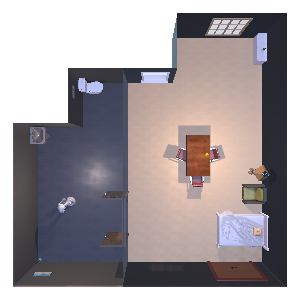

In [43]:
houseId = 6

new_house = dataset["train"][houseId]
controller.reset(scene=new_house)

get_top_down_frame()

## Change House materials

Changing Floors and Ceilings to textured materials

In [44]:
house = dataset["train"][houseId]

#First Attempt, all floors with the same textured material
#Used on datasets proc0, 1, 2, 3, 4, 7, 9, 2wall2 to 2wall11, 3wall1 to 3wall5
#for floors in house["rooms"]:
#    print(floors["floorMaterial"])
#    floors["floorMaterial"]["name"] = "LightWoodCounters"

#Second Attempt, each floor with a different textured material
for i in range(len(house["rooms"])):
    print(house["rooms"][i]["floorMaterial"])
    house["rooms"][i]["floorMaterial"] = {"name": usableFloors[i % len(usableMaterials)]}

print(house["proceduralParameters"]["ceilingMaterial"])
house["proceduralParameters"]["ceilingMaterial"]['name'] = "CeramicTiles1"

{'name': 'LightWoodCounters'}
{'name': 'DarkWoodSmooth2'}
{'name': 'FireplaceTiles'}


# Change Wall Materials

Only run one of the naxt 4 cells.

Setting each wall's texture to the same one

In [ ]:
house = dataset["train"][houseId]

#First Attempt, all walls with the same textured material
#Used on datasets proc0, 1, 2, 3, 4, 7, 9, 2wall2 to 2wall6
for walls in house["walls"]:
    print(walls["material"])
    walls["material"] = {"name": "LivingRoomFireplacebrickTex"}

{'name': 'PureWhite', 'color': {'b': 0.6509803921568628, 'g': 0.7254901960784313, 'r': 0.6901960784313725}}
{'name': 'PureWhite', 'color': {'b': 0.6509803921568628, 'g': 0.7254901960784313, 'r': 0.6901960784313725}}
{'name': 'PureWhite', 'color': {'b': 0.6509803921568628, 'g': 0.7254901960784313, 'r': 0.6901960784313725}}
{'name': 'PureWhite', 'color': {'b': 0.6509803921568628, 'g': 0.7254901960784313, 'r': 0.6901960784313725}}
{'name': 'PureWhite', 'color': {'b': 0.7529411764705882, 'g': 0.8117647058823529, 'r': 0.8509803921568627}}
{'name': 'PureWhite', 'color': {'b': 0.7529411764705882, 'g': 0.8117647058823529, 'r': 0.8509803921568627}}
{'name': 'PureWhite', 'color': {'b': 0.7529411764705882, 'g': 0.8117647058823529, 'r': 0.8509803921568627}}
{'name': 'PureWhite', 'color': {'b': 0.7529411764705882, 'g': 0.8117647058823529, 'r': 0.8509803921568627}}
{'name': 'PureWhite', 'color': {'b': 0.7529411764705882, 'g': 0.8117647058823529, 'r': 0.8509803921568627}}
{'name': 'PureWhite', 'color

Setting each wall's texture to a different one

In [45]:
house = dataset["train"][houseId]

#Second Attempt, each wall with a different textured material
#Used on datasets proc2wall7, proc3wall1, proc3wall4, proc3wall6, proc4wall1, proc6wall1, proc6wall4, proc7wall1
for i in range(len(house["walls"])):
    print(house["walls"][i]["material"])
    house["walls"][i]["material"] = {"name": usableMaterials[i % len(usableMaterials)]}

{'name': 'bathroomTilesGrey 2'}
{'name': 'bathroomTilesGrey 2'}
{'name': 'bathroomTilesGrey 2'}
{'name': 'bathroomTilesGrey 2'}
{'name': 'bathroomTilesGrey 2'}
{'name': 'bathroomTilesGrey 2'}
{'name': 'PureWhite', 'color': {'b': 0.25882352941176473, 'g': 0.26666666666666666, 'r': 0.2627450980392157}}
{'name': 'PureWhite', 'color': {'b': 0.25882352941176473, 'g': 0.26666666666666666, 'r': 0.2627450980392157}}
{'name': 'PureWhite', 'color': {'b': 0.25882352941176473, 'g': 0.26666666666666666, 'r': 0.2627450980392157}}
{'name': 'PureWhite', 'color': {'b': 0.25882352941176473, 'g': 0.26666666666666666, 'r': 0.2627450980392157}}
{'name': 'PureWhite', 'color': {'b': 0.25882352941176473, 'g': 0.26666666666666666, 'r': 0.2627450980392157}}
{'name': 'PureWhite', 'color': {'b': 0.25882352941176473, 'g': 0.26666666666666666, 'r': 0.2627450980392157}}
{'name': 'GreenCountertop'}
{'name': 'GreenCountertop'}
{'name': 'GreenCountertop'}
{'name': 'GreenCountertop'}
{'name': 'GreenCountertop'}
{'name':

Setting each walls's texture to the same one, with differntly colored variations

In [12]:
house = dataset["train"][houseId]

#Third Attempt, each wall with a differently colored version of the same material
#Used on datasets proc2wall9, proc2wall10, proc2wall11, proc3wall2, proc3wall5, proc3wall7, proc4wall2, proc6wall2, proc6wall5, proc7wall2
colors = [[0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 1.0, 0.0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [1.0, 1.0, 1.0]]

for i in range(len(house["walls"])):
    print(house["walls"][i]["material"])
    color = colors[i % len(colors)]
    house["walls"][i]["material"] = {"name": "KitchenTiles3", "color": {"b": color[0], "g": color[1], "r": color[2]}}

{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'WhiteMarble'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}
{'name': 'DarkGraniteDULL'}


Setting each wall's to a differently colored version of different textures

In [ ]:
house = dataset["train"][houseId]

#Fourth Attempt, each wall with a differently colored different material
#Used on datasets proc3wall3, proc4wall3, proc6wall3, proc6wall6
colors = [[0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 1.0, 0.0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [1.0, 1.0, 1.0]]

for i in range(len(house["walls"])):
    print(house["walls"][i]["material"])
    color = colors[i % len(colors)]
    house["walls"][i]["material"] = {"name": usableMaterials[i % len(usableMaterials)], "color": {"b": color[0], "g": color[1], "r": color[2]}}

{'name': 'KitchenTiles3', 'color': {'b': 0.0, 'g': 0.0, 'r': 0.0}}
{'name': 'KitchenTiles3', 'color': {'b': 1.0, 'g': 0.0, 'r': 0.0}}
{'name': 'KitchenTiles3', 'color': {'b': 0.0, 'g': 1.0, 'r': 0.0}}
{'name': 'KitchenTiles3', 'color': {'b': 0.0, 'g': 0.0, 'r': 1.0}}
{'name': 'KitchenTiles3', 'color': {'b': 1.0, 'g': 1.0, 'r': 0.0}}
{'name': 'KitchenTiles3', 'color': {'b': 1.0, 'g': 0.0, 'r': 1.0}}
{'name': 'KitchenTiles3', 'color': {'b': 0.0, 'g': 1.0, 'r': 1.0}}
{'name': 'KitchenTiles3', 'color': {'b': 1.0, 'g': 1.0, 'r': 1.0}}
{'name': 'KitchenTiles3', 'color': {'b': 0.0, 'g': 0.0, 'r': 0.0}}
{'name': 'KitchenTiles3', 'color': {'b': 1.0, 'g': 0.0, 'r': 0.0}}
{'name': 'KitchenTiles3', 'color': {'b': 0.0, 'g': 1.0, 'r': 0.0}}
{'name': 'KitchenTiles3', 'color': {'b': 0.0, 'g': 0.0, 'r': 1.0}}
{'name': 'KitchenTiles3', 'color': {'b': 1.0, 'g': 1.0, 'r': 0.0}}
{'name': 'KitchenTiles3', 'color': {'b': 1.0, 'g': 0.0, 'r': 1.0}}
{'name': 'KitchenTiles3', 'color': {'b': 0.0, 'g': 1.0, 'r': 1

Reset the house again to apply material changes.

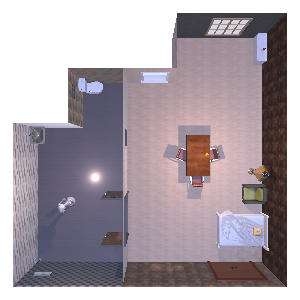

In [46]:
new_house = dataset["train"][houseId]
controller.reset(scene=new_house)

get_top_down_frame()

## Look up

Look up once to look straight forward. Includes less floor and more ceiling this way.

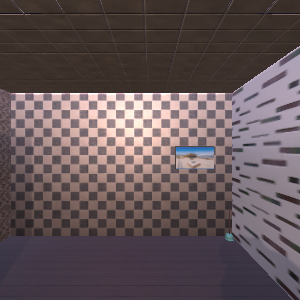

In [47]:
event = controller.step(action="LookUp")
Image.fromarray(event.frame)

Get the reachable positions:

In [48]:
event = controller.step(action="GetReachablePositions")

reachable_positions = event.metadata["actionReturn"]
#Sort the positions, so they are stepped through in order
reachable_positions = sorted(reachable_positions, key=lambda d: d['z'])
reachable_positions = sorted(reachable_positions, key=lambda d: d['x'])

numReachable = len(reachable_positions)
print(numReachable)

1018


## Images at Locations

In [ ]:
#Define the location where the files should be saved
img_location = "/home/ckaese/Documents/LangSplat/datasets/"

For each reachable location: check which two orientations have the largest distance to a wall and choose those images for that position.

In [ ]:
import numpy as np
import json
import os

#Define how many images are wanted and skip enough positions to get approximately that many
imgsWanted = 300
test = (numReachable*2)//imgsWanted
print("Choosing positions every", test)

#Create the four directories that will be saved in, if they do not exist yet
#For images
if not os.path.exists(img_location + 'house' + str(houseId)):
    os.makedirs(img_location + 'house' + str(houseId))
#For segmentation
if not os.path.exists(img_location + 'house' + str(houseId) + "seg"):
    os.makedirs(img_location + 'house' + str(houseId) + "seg")
#For object instance masks
if not os.path.exists(img_location + 'house' + str(houseId) + "instances"):
    os.makedirs(img_location + 'house' + str(houseId) + "instances")
#For bounding boxes of objects
if not os.path.exists(img_location + 'house' + str(houseId) + "bboxes"):
    os.makedirs(img_location + 'house' + str(houseId) + "bboxes")

for pos in range(len(reachable_positions[::test])):
    position = reachable_positions[pos*test]

    maxDistances = [0.0, 0.0]   #Largest and second-largest value start with float 0
    correctRotations = [0, 0]   #Store the amounts the point of view should be rotated by
    for rot in range(12):
        #Teleporting to position with rotation
        event = controller.step(action="Teleport", position=position, rotation=rot*30)

        #Get the depth image
        depthImg = event.depth_frame
        try:
            #Get the average depth, ignoring any distances greater than 19.9,
            #which occur when looking out of a window and should not count as large distances here.
            distance = np.average(depthImg, weights=depthImg<19.9)
        except ZeroDivisionError:
            distance = 0.0
        
        #Save the largest distances in order
        if distance > maxDistances[0]:
            maxDistances[1] = maxDistances[0]
            maxDistances[0] = distance
            correctRotations[1] = correctRotations[0]
            correctRotations[0] = rot*30
        elif distance > maxDistances[1]:
            maxDistances[1] = distance
            correctRotations[1] = rot*30
    
    for correctRotation in correctRotations:
        #Define image ID under which to save the files
        image_id = f"{(pos*2 + correctRotations.index(correctRotation)):05d}"

        #Teleport to the positions with rotations with max depths
        event = controller.step(action="Teleport", position=position, rotation=correctRotation)

        #Save that view
        img = Image.fromarray(event.frame)
        img.save(img_location + 'house' + str(houseId) + '/' + image_id + ".png")

        #Save the segmentation of the view
        imgseg = Image.fromarray(event.instance_segmentation_frame)
        imgseg.save(img_location + 'house' + str(houseId) + "seg" + '/' + image_id + ".png")

        #Save the segmentation masks for each object in view
        instance_masks = dict(event.instance_masks)
        for instance in instance_masks.keys():
            mask = Image.fromarray(instance_masks[instance])
            mask.save(img_location + 'house' + str(houseId) + "instances/" + image_id + "_" + instance + ".png")
        
        #Save the bounding boxes for all objects in view
        with open(img_location + 'house' + str(houseId) + "bboxes/" + image_id + ".json", "w") as f:
            json.dump(dict(event.instance_detections2D), f, ensure_ascii=False, indent=4)

Choosing positions every 6


# More Details

For more details about how to use AI2-THOR, please checkout the API references at [ai2thor.allenai.org](https://ai2thor.allenai.org).